In [91]:
# Getting the data generators for the training and validation sets
import os
import sys

module_path = os.path.abspath('../utils')
print("Adding to sys.path:", module_path)
sys.path.append(module_path)

from data_prep import get_data_generators
train_gen, valid_gen, full_gen, _ = get_data_generators('../data/pokemon.csv', '../data/pokemon-img/pokemon/pokemon/', img_size=(32,32))

Adding to sys.path: c:\Users\halod\Documents\Projects\poke_classy\utils
{'bug': 0, 'dark': 1, 'dragon': 2, 'electric': 3, 'fairy': 4, 'fighting': 5, 'fire': 6, 'flying': 7, 'ghost': 8, 'grass': 9, 'ground': 10, 'ice': 11, 'normal': 12, 'poison': 13, 'psychic': 14, 'rock': 15, 'steel': 16, 'water': 17}
Found 576 validated image filenames.
Found 145 validated image filenames.
Found 721 validated image filenames.


(16, 32, 32, 3) (16, 18)


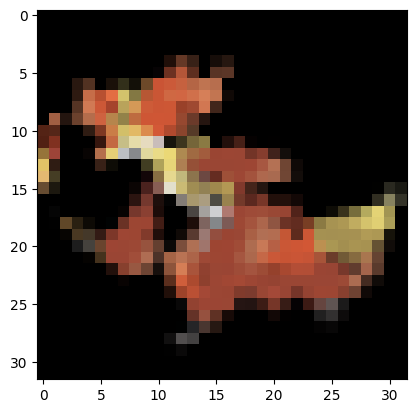

In [101]:
import matplotlib.pyplot as plt
x, y = next(train_gen)
print(x.shape, y.shape)

plt.imshow(x[2])
plt.show()

In [99]:
# defining the model based on the base model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l2

model = models.Sequential([
    Conv2D(32, (3,3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),


    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(18, kernel_regularizer=l2(0.01))
])

model.compile(
    optimizer=Adam(1e-4),
    loss=BinaryCrossentropy(from_logits=True),  # For multi-label
    metrics=[AUC(name='auc', multi_label=True), Precision(name='precision', thresholds=0.4), Recall(name='recall',thresholds=0.4)]
)
model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_117 (B  (None, 32, 32, 32)        128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_117 (MaxPool  (None, 16, 16, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_119 (Conv2D)         (None, 14, 14, 32)        9248      
                                                                 
 batch_normalization_118 (B  (None, 14, 14, 32)        128       
 atchNormalization)                                              
                                                     

In [100]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',patience=15, verbose=0
)

history = model.fit(train_gen, 
                   epochs=500, 
                   validation_data=valid_gen, 
                   callbacks=[early_stopping], 
                   verbose=1)


Epoch 1/500
36/36 [==============================] - 3s 39ms/step - loss: 1.1085 - auc: 0.4958 - precision: 0.0803 - recall: 0.2595 - val_loss: 1.0176 - val_auc: 0.5108 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/500
36/36 [==============================] - 1s 29ms/step - loss: 0.7849 - auc: 0.5189 - precision: 0.1085 - recall: 0.1015 - val_loss: 1.0188 - val_auc: 0.5241 - val_precision: 0.1101 - val_recall: 0.0563
Epoch 3/500
36/36 [==============================] - 1s 32ms/step - loss: 0.7118 - auc: 0.4996 - precision: 0.0975 - recall: 0.0358 - val_loss: 1.0054 - val_auc: 0.5172 - val_precision: 0.0634 - val_recall: 0.0845
Epoch 4/500
36/36 [==============================] - 1s 30ms/step - loss: 0.6947 - auc: 0.4982 - precision: 0.0780 - recall: 0.0185 - val_loss: 0.9590 - val_auc: 0.5193 - val_precision: 0.0886 - val_recall: 0.0986
Epoch 5/500
36/36 [==============================] - 1s 30ms/step - loss: 0.6750 - auc: 0.5024 - precision: 0.1000 - recall: 0.0208 - va

46/46 - 1s - loss: 0.2538 - auc: 0.5487 - precision: 0.7879 - recall: 0.0722 - 820ms/epoch - 18ms/step
[0.2537732720375061, 0.5487200617790222, 0.7878788113594055, 0.07222222536802292]
10/10 - 0s - loss: 0.2933 - auc: 0.5243 - precision: 0.4706 - recall: 0.0376 - 181ms/epoch - 18ms/step
[0.2933242917060852, 0.5242528319358826, 0.47058823704719543, 0.03755868598818779]


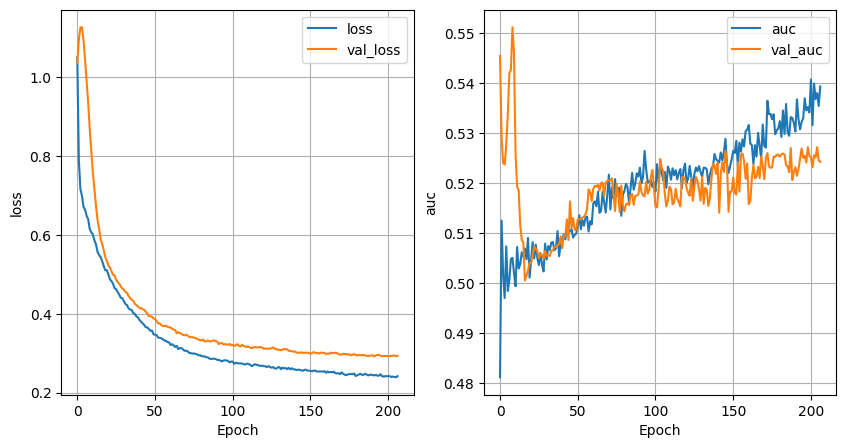

In [96]:
keys = list(history.history.keys())

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes.reshape(-1, 1)


for idx, ax in enumerate(axes): 

    axes[idx].plot(history.history[keys[idx]], label=keys[idx])
    axes[idx].plot(history.history["val_" + keys[idx]], label = "val_" + keys[idx])
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel(keys[idx])
    axes[idx].legend()
    axes[idx].grid(True)

print( model.evaluate(full_gen, verbose=2)); 
print( model.evaluate(valid_gen, verbose=2)); 
# print("\n\nLoss on test set {:.3},  Categorical accuracy on test set {:.3f}, AUC {:.3f}".format(test_loss, test_acc, auc))

In [62]:

model.save('../models/poke_type_(64x64,0.74auc)v2.h5')
print("✅ Model saved")

✅ Model saved
